# Comparison of solvers for 2D Navier-Stokes equations
In this notebook we compare the *implementation and performance* of different solvers for the 2D Navier-Stokes equations.
We consider the following methods:
* `IncompressibleNavierStokes.jl`
* SciML, scpecifically `DifferentialEquations.jl`
* `CoupledNODE.jl`: an in-house wrapper for SciML neural closures.

Setup and initial condition

In [2]:
using GLMakie
import IncompressibleNavierStokes as INS
T = Float32
ArrayType = Array
Re = T(1_000)
n = 256
lims = T(0), T(1)
x, y = LinRange(lims..., n + 1), LinRange(lims..., n + 1)
setup = INS.Setup(x, y; Re, ArrayType);
ustart = INS.random_field(setup, T(0));
psolver = INS.psolver_spectral(setup);
dt = T(1e-3)
trange = (T(0), T(10))
savevery = 20
saveat = savevery * dt;

## IncompressibleNavierStokes.jl solver
We know that mathematically it is the best one.
First, call to get the plots.
Look at the generated animation of the evolution of the vorticity field in time in plots/vorticity_INS.mkv.

In [3]:
(state, outputs), time_ins2, allocation2, gc2, memory_counters2 = @timed INS.solve_unsteady(; setup, ustart, tlims = trange, Δt = dt,
    processors = (
        ehist = INS.realtimeplotter(;
            setup, nupdate = 10, displayfig = false,
            plot = INS.energy_history_plot),
        anim = INS.animator(;
            setup, path = "./simulations/NavierStokes_2D/plots/vorticity_INS.mkv",
            nupdate = savevery),
        #espec = realtimeplotter(; setup, plot = energy_spectrum_plot, nupdate = 10),
        field = INS.fieldsaver(; setup, nupdate = savevery),
        log = INS.timelogger(; nupdate = 100)
    )
);

Iteration 100	t = 0.1	Δt = 0.001	umax = 2.94716
Iteration 200	t = 0.2	Δt = 0.001	umax = 2.60922
Iteration 300	t = 0.3	Δt = 0.000999987	umax = 1.93674
Iteration 400	t = 0.399998	Δt = 0.000999987	umax = 1.81722
Iteration 500	t = 0.499997	Δt = 0.000999987	umax = 1.66464
Iteration 600	t = 0.599996	Δt = 0.000999987	umax = 1.59957
Iteration 700	t = 0.699995	Δt = 0.000999987	umax = 1.3922
Iteration 800	t = 0.799993	Δt = 0.000999987	umax = 1.32724
Iteration 900	t = 0.899992	Δt = 0.000999987	umax = 1.15229
Iteration 1000	t = 0.999991	Δt = 0.000999987	umax = 1.25634
Iteration 1100	t = 1.1	Δt = 0.00100005	umax = 1.24546
Iteration 1200	t = 1.2	Δt = 0.00100005	umax = 1.10215
Iteration 1300	t = 1.3	Δt = 0.00100005	umax = 1.12894
Iteration 1400	t = 1.40001	Δt = 0.00100005	umax = 1.16041
Iteration 1500	t = 1.50001	Δt = 0.00100005	umax = 1.15735
Iteration 1600	t = 1.60002	Δt = 0.00100005	umax = 1.11329
Iteration 1700	t = 1.70002	Δt = 0.00100005	umax = 1.04566
Iteration 1800	t = 1.80003	Δt = 0.00100005	

Second, call to time it (without spending time in animations ~ 5% extra)

In [4]:
_, time_ins, allocation, gc, memory_counters = @timed INS.solve_unsteady(;
    setup, ustart, tlims = trange, Δt = dt);

## SciML
### Projected force for SciML

In [5]:
import DifferentialEquations: ODEProblem, solve, RK4
# create some cache variables so that we do not have to allocate them at every time step
F = similar(stack(ustart));
cache_F = (F[:, :, 1], F[:, :, 2]);
cache_div = INS.divergence(ustart, setup);
cache_p = INS.pressure(ustart, nothing, 0.0f0, setup; psolver);
cache_out = similar(F);

* Right-hand-side out-of-place

In [6]:
function create_rhs_op(setup, psolver, cache_F, cache_div, cache_p, cache_out)
    function right_hand_side(u, p = nothing, t = nothing)
        u = eachslice(u; dims = 3)
        INS.apply_bc_u!(u, t, setup)
        INS.momentum!(cache_F, u, nothing, t, setup)
        INS.apply_bc_u!(cache_F, t, setup; dudt = true)
        INS.project!(cache_F, setup; psolver, div = cache_div, p = cache_p)
        INS.apply_bc_u!(cache_F, t, setup; dudt = true)
        return stack(cache_F)
    end
end

create_rhs_op (generic function with 1 method)

Test the forces

_Note:_ Requires `stack(u)` to create one array

In [7]:
F_op = create_rhs_op(setup, psolver, cache_F, cache_div, cache_p, cache_out);
F_op(stack(ustart), nothing, 0.0f0);
prob_op = ODEProblem(F_op, stack(ustart), trange);

* Right-hand-side in-place

In [8]:
function create_rhs_ip(setup, psolver, cache_F, cache_div, cache_p, cache_out)
    function right_hand_side(du, u, p = nothing, t = nothing)
        u = eachslice(u; dims = 3)
        INS.apply_bc_u!(u, t, setup)
        INS.momentum!(cache_F, u, nothing, t, setup)
        INS.apply_bc_u!(cache_F, t, setup; dudt = true)
        INS.project!(cache_F, setup; psolver, div = cache_div, p = cache_p)
        INS.apply_bc_u!(cache_F, t, setup; dudt = true)
        du[:, :, 1] = cache_F[1]
        du[:, :, 2] = cache_F[2]
        nothing
    end
end

temp = similar(stack(ustart))
F_ip = create_rhs_ip(setup, psolver, cache_F, cache_div, cache_p, cache_out);
F_ip(temp, stack(ustart), nothing, 0.0f0)

Solve the ODE using `ODEProblem`. We use `RK4` (Runge-Kutta 4th order) because this same method is used in `IncompressibleNavierStokes.jl`.

In [9]:
prob = ODEProblem{true}(F_ip, stack(ustart), trange);
sol_ode, time_ode, allocation_ode, gc_ode, memory_counters_ode = @timed solve(
    prob, RK4(); dt = dt, saveat = saveat);

Test the difference between in-place and out-of-place definitions

In [ ]:
@time sol = solve(prob, RK4(); dt = dt, saveat = saveat);

In place: `46.664913 seconds (8.02 M allocations: 500.621 MiB, 0.07% gc time)`

In [ ]:
@time sol = solve(prob_op, RK4(); dt = dt, saveat = saveat);

Out of place: `53.804647 seconds (8.36 M allocations: 84.888 GiB, 2.96% gc time)`

## CNODE

In [10]:
import DiffEqFlux: NeuralODE
import CoupledNODE: create_f_CNODE
f_dns = create_f_CNODE((F_op,); is_closed = false);
import Random, Lux;
Random.seed!(123);
rng = Random.default_rng();
θ_dns, st_dns = Lux.setup(rng, f_dns);

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


Define the problem and solve it

In [11]:
dns = NeuralODE(f_dns, trange, RK4(), adaptive = false, dt = dt, saveat = saveat);
sol_node, time_node, allocation_node, gc_node, memory_counters_node = @timed dns(
    stack(ustart), θ_dns, st_dns)[1];

## Comparison
Bar plots comparing: time, memory allocation, and number of garbage collections (GC).

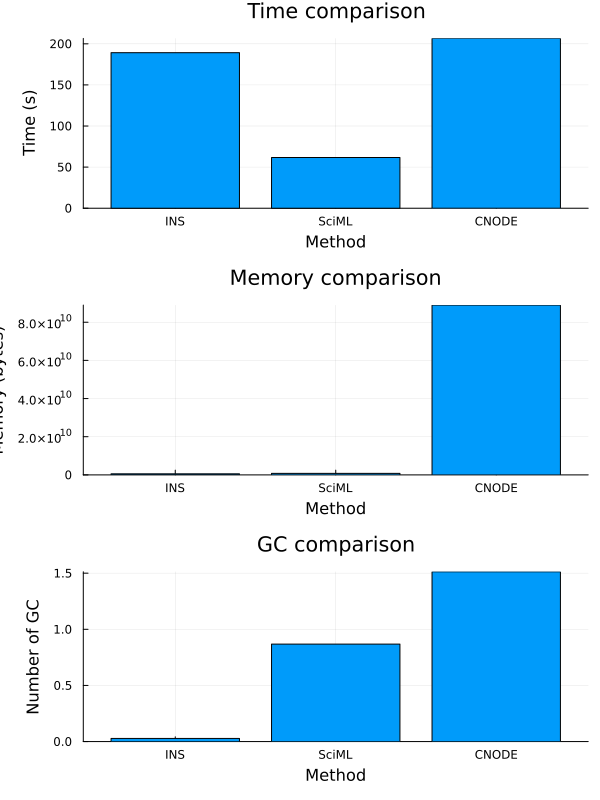

In [12]:
import Plots
p1 = Plots.bar(["INS", "SciML", "CNODE"], [time_ins, time_ode, time_node],
    xlabel = "Method", ylabel = "Time (s)", title = "Time comparison", legend = false);
#Memory allocation
p2 = Plots.bar(["INS", "SciML", "CNODE"],
    [memory_counters.allocd, memory_counters_ode.allocd, memory_counters_node.allocd],
    xlabel = "Method", ylabel = "Memory (bytes)",
    title = "Memory comparison", legend = false);
#Garbage collections
p3 = Plots.bar(["INS", "SciML", "CNODE"], [gc, gc_ode, gc_node], xlabel = "Method",
    ylabel = "Number of GC", title = "GC comparison", legend = false);

Plots.plot(p1, p2, p3, layout = (3, 1), size = (600, 800))

### Plots: final state of $u$

In [ ]:
using Plots
p1 = Plots.heatmap(title = "\$u\$ SciML ODE", sol_ode.u[end][:, :, 1], ticks = false);
p2 = Plots.heatmap(title = "\$u\$ SciML CNODE", sol_node.u[end][:, :, 1], ticks = false);
p3 = Plots.heatmap(title = "\$u\$ INS", state.u[1], ticks = false);
p4 = Plots.heatmap(title = "\$u_{INS}-u_{ODE}\$",
    state.u[1] - sol_ode.u[end][:, :, 1], ticks = false);
p5 = Plots.heatmap(title = "\$u_{INS}-u_{CNODE}\$",
    state.u[1] - sol_node.u[end][:, :, 1], ticks = false);
p6 = Plots.heatmap(title = "\$u_{CNODE}-u_{ODE}\$",
    sol_node.u[end][:, :, 1] - sol_ode.u[end][:, :, 1], ticks = false);
Plots.plot(p1, p2, p3, p4, p5, p6, layout = (2, 3), size = (900, 600), ticks = false)

### Plots: vorticity

In [ ]:
vins = INS.vorticity((state.u[1], state.u[2]), setup)
vode = INS.vorticity((sol_ode.u[end][:, :, 1], sol_ode.u[end][:, :, 2]), setup)
vnode = INS.vorticity((sol_node.u[end][:, :, 1], sol_node.u[end][:, :, 2]), setup)
vor_lims = (-5, 5)
diff_lims = (-0.4, 0.4)

p1 = Plots.heatmap(title = "\$\\omega\$ SciML ODE", vode,
    color = :viridis, ticks = false, clims = vor_lims);
p2 = Plots.heatmap(title = "\$\\omega\$ in SciML CNODE", vnode,
    color = :viridis, ticks = false, clims = vor_lims);
p3 = Plots.heatmap(title = "vorticity \$(\\omega)\$ in INS", vins,
    color = :viridis, ticks = false, clims = vor_lims);
p4 = Plots.heatmap(title = "\$\\omega_{INS}-\\omega_{ODE}\$",
    vins - vode, clim = diff_lims, ticks = false);
p5 = Plots.heatmap(title = "\$\\omega_{INS}-\\omega_{CNODE}\$",
    vins - vnode, clim = diff_lims, ticks = false);
p6 = Plots.heatmap(title = "\$\\omega_{CNODE}-\\omega_{ODE}\$",
    vode - vnode, ticks = false, clim = (0, 0.2));
Plots.plot(p1, p2, p3, p4, p5, p6, layout = (2, 3), size = (900, 600))

### Divergence:

INS

In [ ]:
#div_INS = fill!(similar(setup.grid.x[1], setup.grid.N), 0)
#INS.divergence!(div_INS, state.u, setup)
div_INS = INS.divergence(state.u, setup)
maximum(abs.(div_INS))

SciML

In [ ]:
u_last_ode = (sol_ode.u[end][:, :, 1], sol_ode.u[end][:, :, 2]);
div_ode = INS.divergence(u_last_ode, setup)
max_div_ode = maximum(abs.(div_ode))

using Printf
anim = Animation()
for (idx, (t, u)) in enumerate(zip(sol_ode.t, sol_ode.u))
    ∇_u = INS.divergence((u[:, :, 1], u[:, :, 2]), setup)
    title = @sprintf("\$\\nabla \\cdot u\$ SciML, t = %.3f s", t)
    fig = Plots.heatmap(∇_u'; xlabel = "x", ylabel = "y", title, aspect_ratio = :equal,
        ticks = false, size = (600, 600), clims = (-max_div_ode, max_div_ode))
    frame(anim, fig)
end
gif(anim, "simulations/NavierStokes_2D/plots/divergence_SciML.gif", fps = 15)

CNODE

In [ ]:
u_last_node = (sol_node.u[end][:, :, 1], sol_node.u[end][:, :, 2]);
div_node = INS.divergence(u_last_node, setup)
maximum(abs.(div_node))

**Conclusion:** While IncompressibleNavierStokes.jl guarantees a $\nabla \cdot u =0$ the other methods do not.

### Animations
#### Animate SciML solution using `Makie`
! we can plot either the vorticity or the velocity field, however notice that the vorticity is 'flashing' (unstable)

In [ ]:
let
    (; Iu) = setup.grid
    i = 1
    #obs = Observable(sol.u[1][Iu[i], i])
    obs = Observable(INS.vorticity((sol_ode.u[1][:, :, 1], sol_ode.u[1][:, :, 2]), setup))
    fig = GLMakie.heatmap(obs, colorrange = vor_lims)
    fig |> display
    for u in sol_ode.u
        #obs[] = u[Iu[i], i]
        obs[] = INS.vorticity((u[:, :, 1], u[:, :, 2]), setup)
        #fig |> display
        sleep(0.05)
    end
end

#### Animate SciML solution using `Plots.jl`

In [ ]:
function animation_plots(; variable = "vorticity")
    anim = Animation()
    for (idx, (t, u)) in enumerate(zip(sol_ode.t, sol_ode.u))
        if variable == "vorticity"
            ω = INS.vorticity((u[:, :, 1], u[:, :, 2]), setup)
            title = @sprintf("Vorticity SciML, t = %.3f s", t)
            fig = Plots.heatmap(ω'; xlabel = "x", ylabel = "y", title, clims = vor_lims,
                color = :viridis, aspect_ratio = :equal, ticks = false, size = (600, 600))
        else
            title = @sprintf("\$u\$ SciML, t = %.3f s", t)
            fig = Plots.heatmap(u[:, :, 1]; xlabel = "x", ylabel = "y", title,
                aspect_ratio = :equal, ticks = false, size = (600, 600))
        end
        frame(anim, fig)
    end
    if variable == "vorticity"
        gif(anim, "simulations/NavierStokes_2D/plots/vorticity_SciML.gif", fps = 15)
    else
        gif(anim, "simulations/NavierStokes_2D/plots/velocity_SciML.gif", fps = 15)
    end
end

Vorticity animation

In [ ]:
animation_plots(; variable = "vorticity")

Velocity animation

In [ ]:
animation_plots(; variable = "velocity")

#### Animate the difference in solution using `Plots.jl`

In [ ]:
anim = Animation()
for idx in 1:Int(ceil(trange[end] / saveat))

the ODESolution saves the initial state too

In [ ]:
    error_u = abs.(outputs.field[idx].u[1] - sol_ode.u[idx + 1][:, :, 1])
    title = @sprintf("\$|u_{INS}-u_{ODE}|\$, t = %.3f s", sol_ode.t[idx])
    fig = Plots.heatmap(error_u; xlabel = "x", ylabel = "y", title,
        aspect_ratio = :equal, ticks = false, size = (600, 600))
    frame(anim, fig)
end
gif(anim, "simulations/NavierStokes_2D/plots/u_INS-SciML.gif", fps = 15)

### Different initial conditions

In [ ]:
t_range_bench = (T(0), T(1))
function bench_INS(ustart)
    INS.solve_unsteady(; setup, ustart, tlims = t_range_bench, Δt = dt)
end

function bench_ode(u0)
    prob = ODEProblem{true}(F_ip, stack(u0), t_range_bench)
    solve(prob, RK4(); dt = dt, saveat = saveat)
end

using Statistics
total_diff, avg_diff, rel_error = [], [], [];
samples = 1:100;
for _ in samples
    ustart = INS.random_field(setup, T(0))
    state, _ = bench_INS(ustart)
    sol_ode = bench_ode(ustart)
    push!(total_diff, sum(abs.(state.u[1] - sol_ode.u[end][:, :, 1])))
    push!(avg_diff, mean(abs.(state.u[1] - sol_ode.u[end][:, :, 1])))
    #push!(rel_error, mean(abs.((state.u[1] - sol_ode.u[end][:, :, 1])/state.u[1]))) # zero division
end

Plots.histogram(total_diff, bins = 20, label = "Total error",
    xlabel = "\$\\sum(|u_{INS}-u_{ODE}|)\$")
Plots.histogram(avg_diff, bins = 20, label = "Mean absolute error",
    xlabel = "\$\\langle |u_{INS}-u_{ODE}|\\rangle \$")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*